In [1]:
import sys
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# 2. Import tf_keras first
import tf_keras

# 3. THE TRICK: Tell Python that 'keras' is actually 'tf_keras'
# This forces keras_tuner to use tf_keras internally.
sys.modules["keras"] = tf_keras
import tf_keras as keras 
import pandas as pd

# get current file path using pathlib
from pathlib import Path


BASE_PATH = Path('../../data/social-media-extremism-detection-challenge')
train_df = pd.read_csv(BASE_PATH / 'train.csv')
test_df = pd.read_csv(BASE_PATH / 'test.csv')
cols=['ID',	'Original_Message','Extremism_Label']
# change column names
train_df.columns=cols

NameError: name 'plt' is not defined

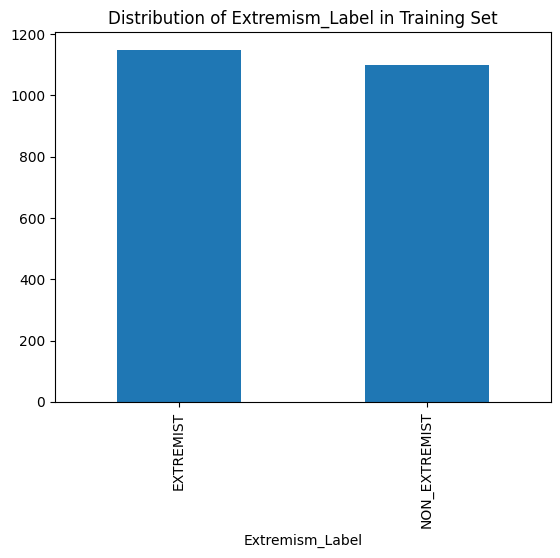

In [ ]:
# plot distribution of 'Extremism_Label' in train_df
import matplotlib.pyplot as plt
train_df['Extremism_Label'].value_counts().plot(kind='bar', title='Distribution of Extremism_Label in Training Set')
plt.show()
train_df.isna().sum()

In [3]:
# get the row where 'Original_Message' is NaN
train_df[train_df['Original_Message'].isna()]

,ID,Original_Message,Extremism_Label
1228,1229,NaN,NON_EXTREMIST


In [4]:
# set 'Original_Message' to empty string where it is NaN
train_df['Original_Message'] = train_df['Original_Message'].fillna('empty')

In [5]:
import tensorflow as tf
import numpy as np
from transformers import TFAutoModel, AutoTokenizer
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [6]:
class CFG:
    seed = 42  # Random seed
    preset = "distilbert-base-uncased"# "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 256  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 4  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    label_cols = [
        'Extremism_Label']  # Target labels
    text_col = 'Original_Message'  # Input text column
    learning_rate = 2e-5  # Learning rate
    dropout_rate = 0.3  # Dropout rate


In [7]:
tokenizer=AutoTokenizer.from_pretrained(CFG.preset)
def create_dataset(examples, shuffle=False, repeat=False, batch_size=CFG.batch_size, tokenizer=tokenizer):
    # check if any of the examples is empty string
    if any(x == "" for x in examples[CFG.text_col].tolist()):
        examples[CFG.text_col] = [
            x if x != "" else "empty" for x in examples[CFG.text_col].tolist()
        ]
    encoding = tokenizer(
            examples[CFG.text_col].tolist(),
            padding='max_length',
            truncation=True,
            max_length=CFG.sequence_length,
            return_tensors='tf',
    )    
    # check if  its a train or test dataset
    if CFG.label_cols[0] not in examples.columns:
        ds = tf.data.Dataset.from_tensor_slices(dict(encoding))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(examples), seed=CFG.seed)
        if repeat:
            ds = ds.repeat()
        ds = ds.batch(batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:        
        labels = examples[CFG.label_cols].values == "EXTREMIST"
        labels = labels.astype(np.float32)
        ds = tf.data.Dataset.from_tensor_slices((dict(encoding), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(examples), seed=CFG.seed)
        if repeat:
            ds = ds.repeat()
        ds = ds.batch(batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds


In [ ]:
from sklearn.model_selection import train_test_split
# Split train into train and validation
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=CFG.seed, stratify=train_df[CFG.label_cols])
train_ds = create_dataset(train_data, shuffle=True, batch_size=CFG.batch_size)
val_ds = create_dataset(val_data, batch_size=CFG.batch_size)
test_ds = create_dataset(test_df, batch_size=CFG.batch_size)

In [9]:
from sklearn.utils import class_weight
train_df['target'] = (train_df['Extremism_Label'] == 'EXTREMIST').astype(int)

y_integers = train_df['target'].values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: np.float64(1.021798365122616), 1: np.float64(0.97911227154047)}


In [10]:

def build_model():
    input_ids = keras.layers.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='input_ids')
    attention_mask = keras.layers.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name='attention_mask')
    transformer_model = TFAutoModel.from_pretrained(CFG.preset)
    transformer_output = transformer_model(input_ids, attention_mask=attention_mask)
    cls_token = transformer_output.last_hidden_state[:, 0, :]  # CLS token output
    dropout = keras.layers.Dropout(CFG.dropout_rate, name='dropout')(cls_token)
    output = keras.layers.Dense(len(CFG.label_cols), activation='sigmoid', name='output')(dropout)
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CFG.learning_rate),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    return model

In [ ]:

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
oof_preds = np.zeros(len(train_df))
early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor='val_auc', 
        patience=3, 
        mode='max',
        restore_best_weights=True
    )
for fold, (train_index, val_index) in enumerate(skf.split(train_df, train_df['target'])):
    fold_train = train_df.iloc[train_index].copy()
    fold_val = train_df.iloc[val_index].copy()
    fold_train_ds = create_dataset(fold_train, shuffle=True, batch_size=CFG.batch_size)
    fold_val_ds = create_dataset(fold_val, batch_size=CFG.batch_size)
    model = build_model()
    print(f"Training fold {fold + 1}")
    model.fit(
        fold_train_ds,
        validation_data=fold_val_ds,
        epochs=CFG.epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    val_preds = model.predict(fold_val_ds, verbose=0)
    oof_preds[val_index] = val_preds.flatten()
    
    # 8. Clean up
    del model
    import gc
    gc.collect()




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Training fold 1
Epoch 1/3

450/450 [==============================] - 456s 995ms/step - loss: 0.4960 - accuracy: 0.7494 - auc: 0.8341 - precision: 0.7527 - recall: 0.7584 - val_loss: 0.3870 - val_accuracy: 0.8178 - val_auc: 0.9110 - val_precision: 0.7517 - val_recall: 0.9609
Epoch 2/3
450/450 [==============================] - 465s 1s/step - loss: 0.2858 - accuracy: 0.8783 - auc: 0.9488 - precision: 0.8646 - recall: 0.9032 - val_loss: 0.3944 - val_accuracy: 0.8244 - val_auc: 0.9082 - val_precision: 0.7938 - val_recall: 0.8870
Epoch 3/3
450/450 [==============================] - 474s 1s/step - loss: 0.1591 - accuracy: 0.9417 - auc: 0.9844 - precision: 0.9330 - recall: 0.9543 - val_loss: 0.4644 - val_accuracy: 0.8200 - val_auc: 0.9158 - val_precision: 0.8634 - val_recall: 0.7696


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Training fold 2
Epoch 1/3
450/450 [==============================] - 508s 1s/step - loss: 0.4728 - accuracy: 0.7567 - auc: 0.8496 - precision: 0.7594 - recall: 0.7661 - val_loss: 0.3933 - val_accuracy: 0.8178 - val_auc: 0.8946 - val_precision: 0.8136 - val_recall: 0.8348
Epoch 2/3
193/450 [===========>..................] - ETA: 4:20 - loss: 0.2813 - accuracy: 0.8847 - auc: 0.9520 - precision: 0.8790 - recall: 0.8990

KeyboardInterrupt: 

In [14]:
val_preds.flatten()

array([9.97288048e-01, 9.96115446e-01, 9.96896684e-01, 9.98540938e-01,
       9.99874592e-01, 9.92780924e-01, 8.93381476e-01, 9.39213991e-01,
       9.61659849e-01, 3.23175155e-02, 6.69847578e-02, 7.20040858e-01,
       8.20536911e-01, 8.58065903e-01, 2.99995869e-01, 9.50762451e-01,
       8.89523029e-01, 4.61490512e-01, 1.45059004e-01, 7.05869138e-01,
       9.52990234e-01, 4.73891079e-01, 1.16039743e-03, 1.26720276e-02,
       6.25801027e-01, 1.87452689e-01, 3.84618714e-02, 6.77960455e-01,
       3.65130007e-02, 7.90201783e-01, 9.82186079e-01, 2.51724094e-01,
       2.84374177e-01, 1.62208393e-01, 1.54392064e-01, 2.79794753e-01,
       6.30161285e-01, 8.40328395e-01, 1.59953758e-01, 5.18611036e-02,
       9.40649450e-01, 4.53378947e-04, 1.50064737e-01, 5.99629700e-01,
       1.00783527e-01, 7.33551979e-01, 5.08315086e-01, 7.15330362e-01,
       8.64493430e-01, 8.61817449e-02, 3.04211855e-01, 2.61979699e-01,
       9.98212576e-01, 4.20728885e-02, 9.98064756e-01, 9.81663585e-01,
      

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # --- Plot 1: Loss (The most important check) ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Loss (Lower is Better)')
    plt.legend(loc='upper right')
    plt.grid(True)

    # --- Plot 2: AUC (The most robust metric) ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.title('AUC (Higher is Better)')
    plt.legend(loc='lower right')
    plt.grid(True)

    # --- Plot 3: Binary Accuracy (The intuitive metric) ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy (Higher is Better)')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_history(his)


In [ ]:
ds_roc = create_dataset(train_data)
pred_prob =model.predict(ds_roc)


507/507 [==============================] - 114s 226ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# 1. Get Predictions
# Ensure you are using the validation set, NOT the test set for this
val_probs = pred_prob.ravel()
y_true = val_data['Extremism_Label'] == "EXTREMIST" # Make sure this matches your data string

# 2. Calculate ROC components
fpr, tpr, thresholds = roc_curve(y_true, val_probs)
roc_auc = auc(fpr, tpr)

# 3. Calculate Youden's J Statistic
# J = Sensitivity (TPR) + Specificity (1-FPR) - 1
# Simplified: J = TPR - FPR
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"Best Threshold (Youden's J): {best_thresh}")
print(f"ROC AUC: {roc_auc}")

# 4. Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Guess')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best Threshold {best_thresh:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 5. Apply this threshold to Test Set
test_probs = model.predict(test_ds).ravel()
final_predictions = (test_probs > best_thresh).astype(int)
submission = pd.DataFrame()
# convert final_predictions to "EXTREMIST" and "NON-EXTREMIST"
submission['Extremism_Label'] = np.where(final_predictions == 1, "EXTREMIST", "NON-EXTREMIST")
submission['id'] = test_df['ID']
submission.to_csv('submission.csv', index=False)        

ValueError: Found input variables with inconsistent numbers of samples: [225, 2025]